In [1]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Clean up table

In [19]:
df = pd.read_csv("../data/fishes_shok.txt", sep="\s")

df.columns = df.columns.str.replace("\"", "")

for c in ["family", "mode", "mode_scr", "temperature", "time", "enu"]:
    df[c] = df[c].str.replace("\"", "")

df.to_csv("../data/fishes_shok.csv", index=False)

/tmp/ipykernel_52038/3722746610.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("../data/fishes_shok.txt", sep="\s")


## Load data

In [2]:
df = pd.read_csv("../data/fishes_shok.csv").drop(["petri"], axis=1)
df = df[df.swim_per <= 100]
print(df.shape)
df.head()

(239, 16)


,family,mode,mode_scr,temperature,time,enu,dead,alive,total,fertilization_per,hatched,hatched_per,swimming,freaks,swim_per,freaks_per
0,1x1,control,ctrl,20,0,0,9,45,54,83.333333,26,57.777778,23,3,88.461538,11.538462
1,1x1,control,ctrl,20,0,0,4,20,24,83.333333,9,45.000000,5,4,55.555556,44.444444
2,1x1,control,ctrl,20,0,0,4,40,44,90.909091,11,27.500000,10,0,90.909091,0.000000
3,1x1,control,ctrl,20,0,0,2,20,22,90.909091,9,45.000000,8,1,88.888889,11.111111
4,1x1,control,ctrl,20,0,0,5,21,26,80.769231,12,57.142857,11,1,91.666667,8.333333


In [3]:
Y1, Y2, Y3, Y4 = ["fertilization_per", "hatched_per", "swim_per", "freaks_per"]

## EDA

In [4]:
df[[Y1, Y2, Y3, Y4]].describe()

,fertilization_per,hatched_per,swim_per,freaks_per
count,239.000000,239.000000,239.000000,239.000000
mean,66.983671,39.782916,51.982838,21.929598
std,25.232005,32.550511,36.647541,25.803536
min,0.000000,0.000000,0.000000,0.000000
25%,50.471698,5.718954,4.545455,0.000000
50%,72.972973,40.000000,58.333333,12.000000
75%,86.939571,65.881375,84.375000,37.321429
max,100.000000,100.000000,100.000000,100.000000


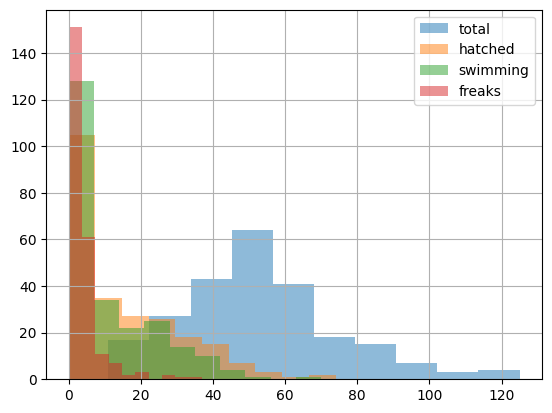

In [5]:
df.total.hist(label="total", alpha=0.5, bins=10)
df.hatched.hist(label="hatched", alpha=0.5, bins=10)
df.swimming.hist(label="swimming", alpha=0.5, bins=10)
df.freaks.hist(label="freaks", alpha=0.5, bins=10)
plt.legend()
plt.show()

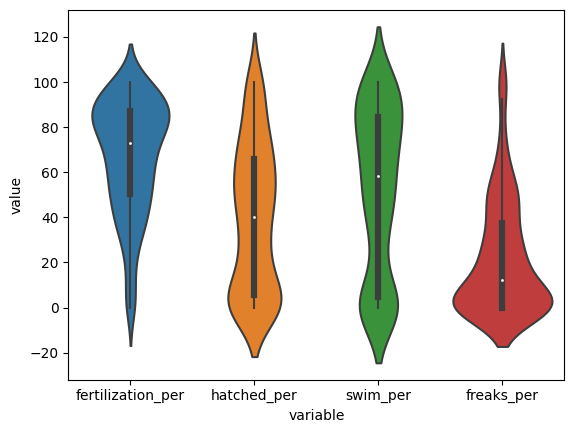

In [25]:
x = df[[Y1, Y2, Y3, Y4]].melt()
sns.violinplot(data=x, x="variable", y="value");

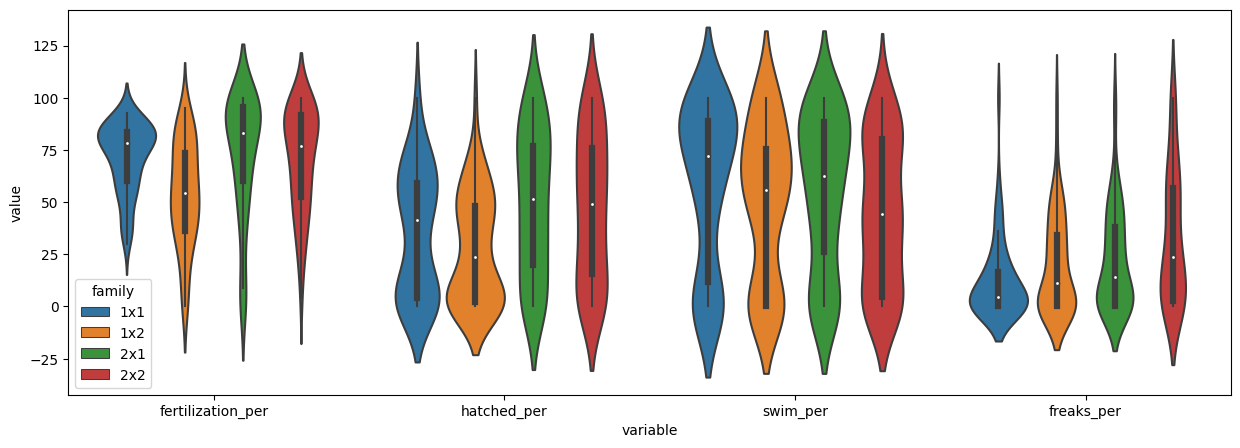

In [14]:
x = df[["family", Y1, Y2, Y3, Y4]].melt("family")
plt.figure(figsize=(15, 5))
sns.violinplot(data=x, x="variable", y="value", hue="family");

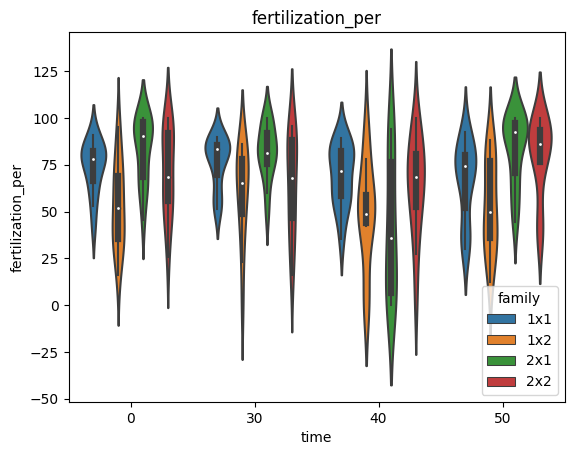

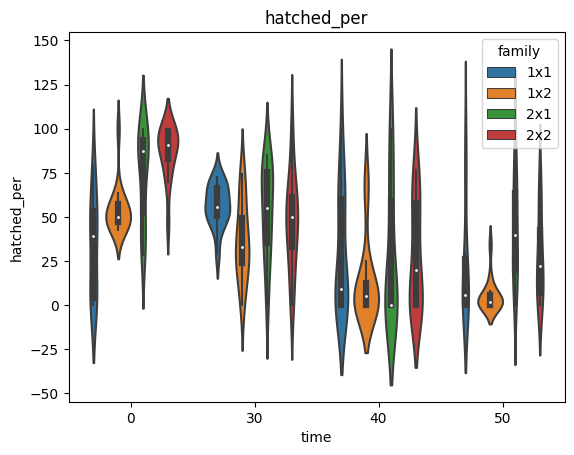

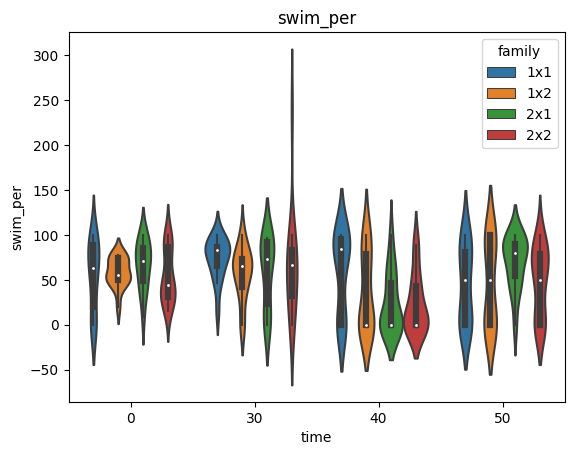

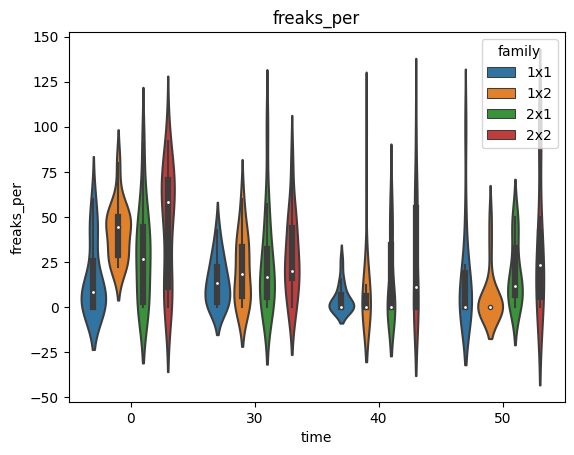

In [14]:
# only time
for y in [Y1, Y2, Y3, Y4]:
    plt.title(y)
    sns.violinplot(data=df, x="time", y=y, hue="family")
    plt.show()

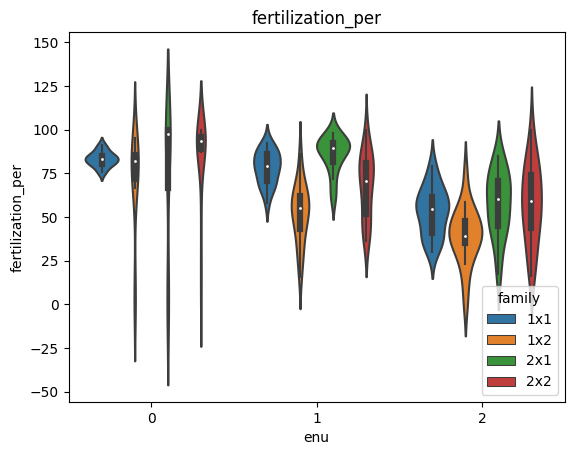

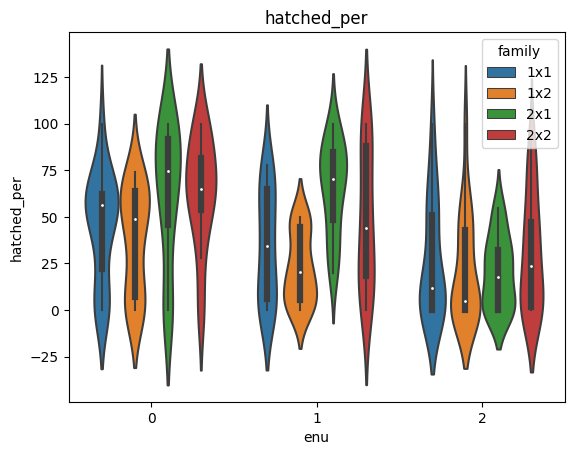

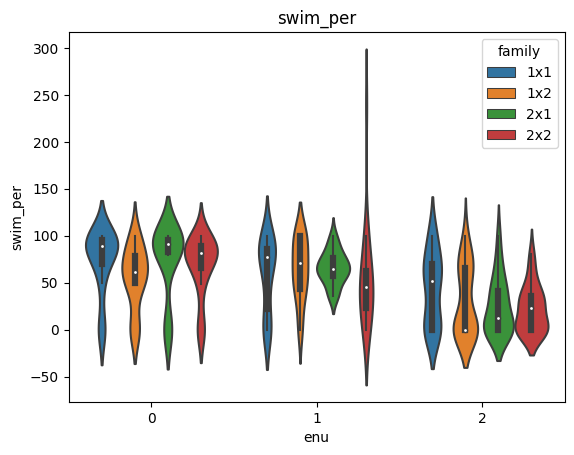

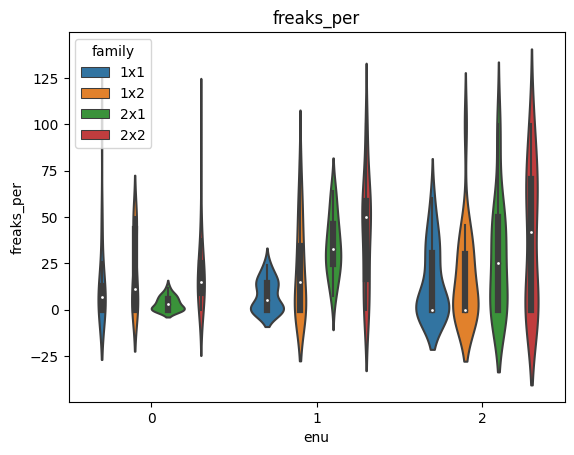

In [10]:
# only enu
for y in [Y1, Y2, Y3, Y4]:
    plt.title(y)
    sns.violinplot(data=df, x="enu", y=y, hue="family")
    plt.show()

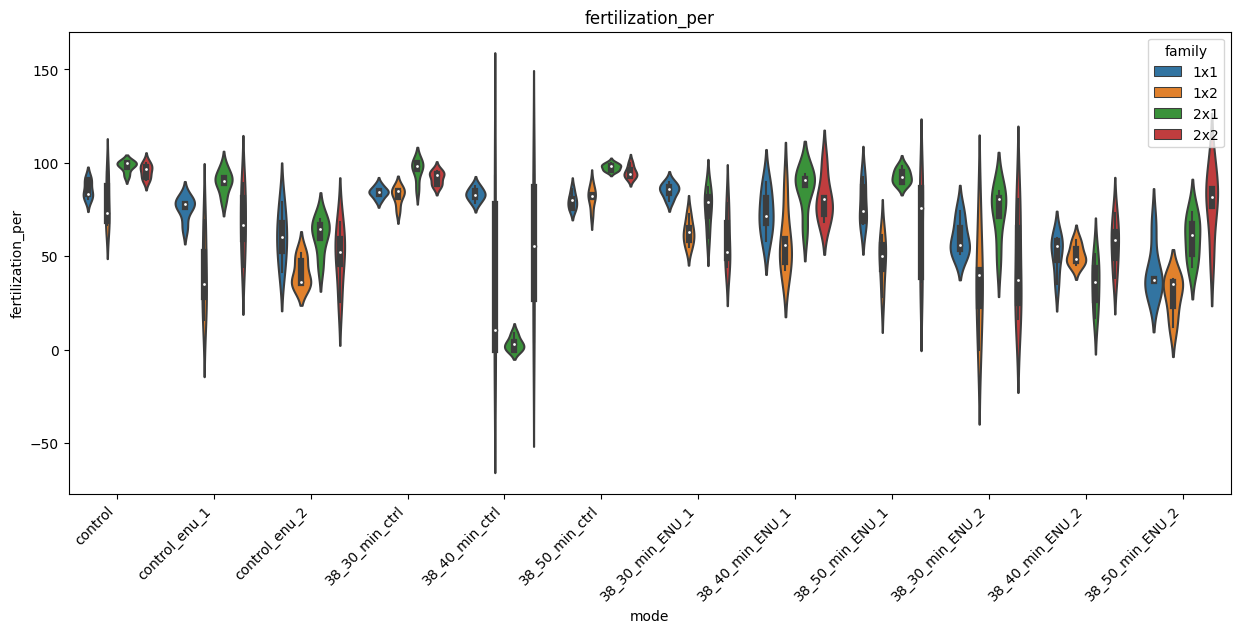

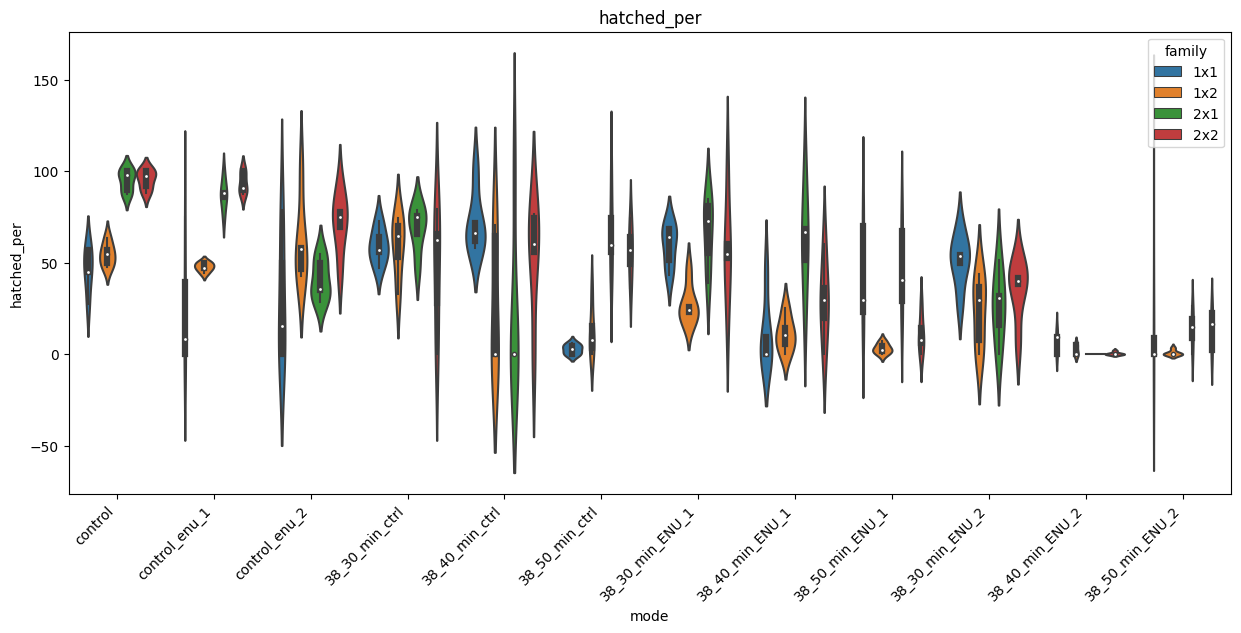

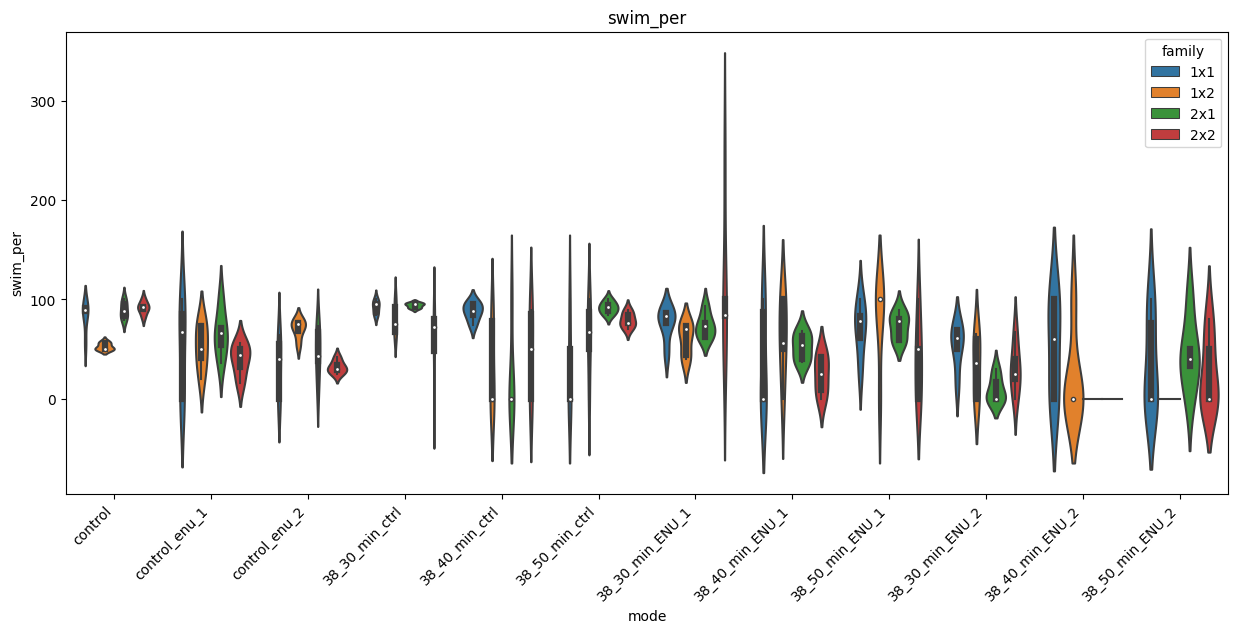

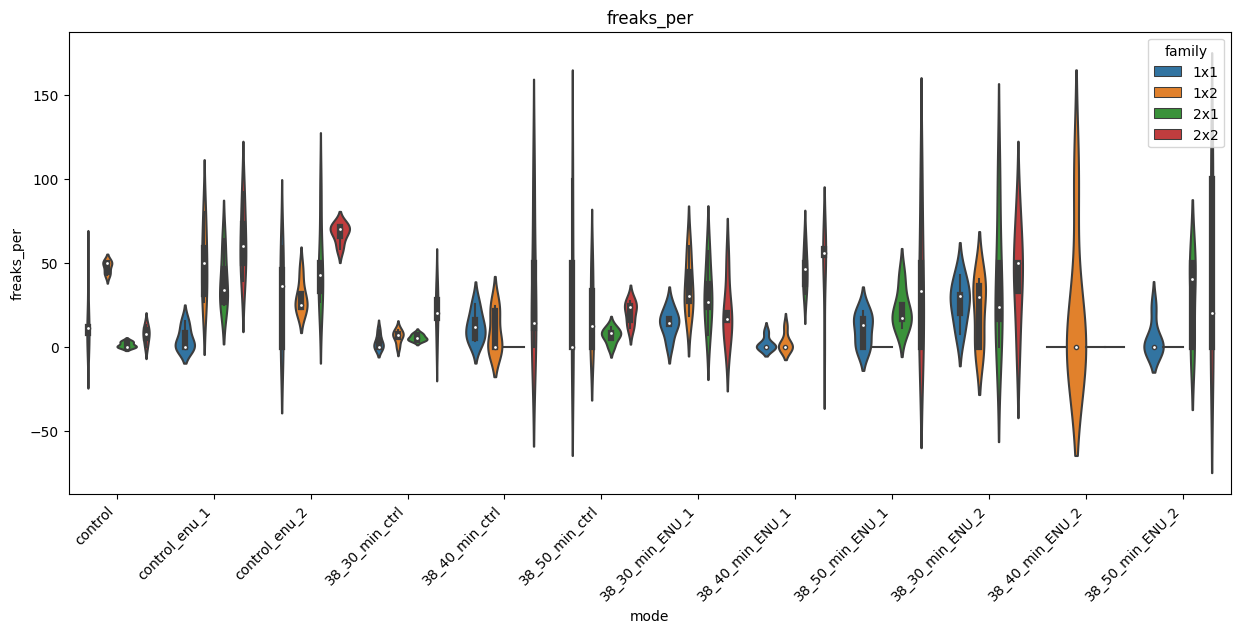

In [11]:
# mode
for y in [Y1, Y2, Y3, Y4]:
    plt.figure(figsize=(15, 6))
    plt.title(y)
    sns.violinplot(data=df, x="mode", y=y, hue="family")
    plt.xticks(rotation=45, ha="right")
    plt.show()

In [33]:
ava = df.groupby(["time", "enu"])[[Y1, Y2, Y3, Y4]].mean()
ava

fertilization_per  hatched_per   swim_per  freaks_per
time enu                                                       
0    0            89.489921    72.909033  79.115828   17.687837
     1            68.500944    63.258711  51.735016   38.986594
     2            53.291559    50.586937  44.972892   43.548933
30   0            88.734610    58.504394  80.683836    8.727856
     1            71.940075    52.666998  71.539540   23.919752
     2            53.634416    33.987631  31.214978   32.052914
40   0            44.035402    42.974877  46.059609   14.049086
     1            74.502368    28.211484  43.729677   23.801417
     2            48.339003     2.237695  18.000000    5.000000
50   0            88.492618    34.224246  65.435005   19.029860
     1            70.848079    26.099569  65.795317   17.273967
     2            52.242883    12.377621  26.490196   19.176471

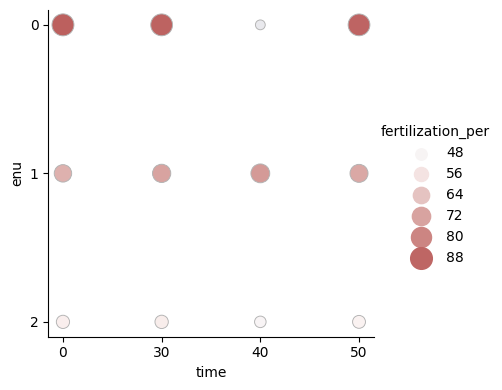

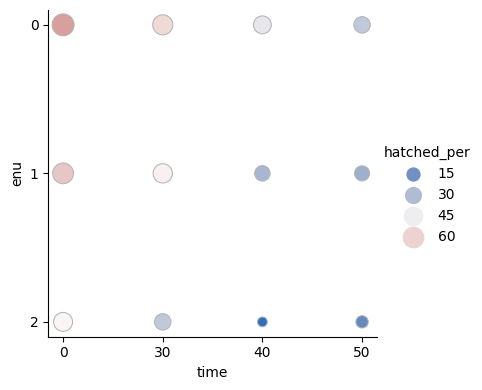

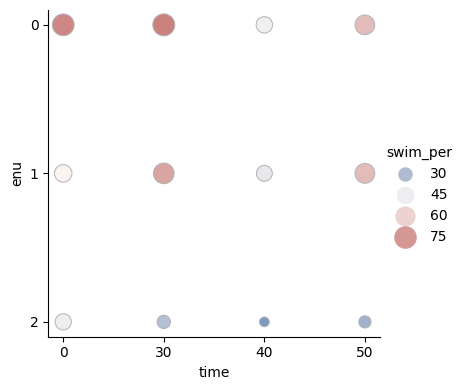

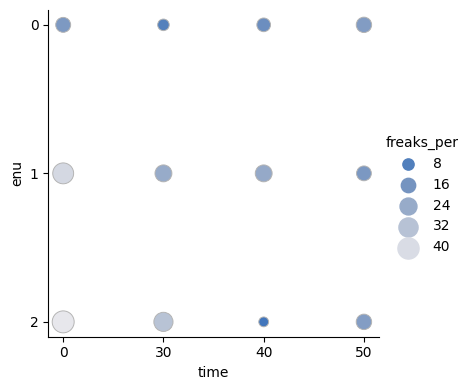

In [34]:
for y in [Y1, Y2, Y3, Y4]:
    x = ava[y].reset_index()
    x["time"] = x["time"].astype(str)
    x["enu"] = x["enu"].astype(str)
    sns.relplot(
        data=x, 
        x="time", y="enu", hue=y, size=y,
        palette="vlag", hue_norm=(0, 100), edgecolor=".7",
        height=4, sizes=(50, 250), 
    )
    plt.show()

## Model

### Features

In [15]:
df["mom"] = df.family.str.get(0).astype(np.int8)
df["dad"] = df.family.str.get(2).astype(np.int8)

In [16]:
X = pd.concat([pd.get_dummies(df[c], f"dummy_{c}") for c in ["time", "enu", "mom", "dad"]], axis=1)
X

,dummy_time_0,dummy_time_30,dummy_time_40,dummy_time_50,dummy_enu_0,dummy_enu_1,dummy_enu_2,dummy_mom_1,dummy_mom_2,dummy_dad_1,dummy_dad_2
0,1,0,0,0,1,0,0,1,0,1,0
1,1,0,0,0,1,0,0,1,0,1,0
2,1,0,0,0,1,0,0,1,0,1,0
3,1,0,0,0,1,0,0,1,0,1,0
4,1,0,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
235,0,0,0,1,0,0,1,0,1,0,1
236,0,0,0,1,0,0,1,0,1,0,1
237,0,0,0,1,0,0,1,0,1,0,1
238,0,0,0,1,0,0,1,0,1,0,1


In [17]:
import statsmodels.api as sm
# from sklearn.preprocessing import StandardScaler
import tqdm
import scipy.stats

In [31]:
model = sm.GLM(df[[Y1]] / 100, sm.add_constant(X), family=sm.families.Tweedie())
glm_results = model.fit(maxiter=10000)
print(glm_results.summary())

/home/mr/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1582: RuntimeWarning: divide by zero encountered in log
  endog * np.log(endog / mu) + (mu - endog))
/home/mr/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1582: RuntimeWarning: invalid value encountered in multiply
  endog * np.log(endog / mu) + (mu - endog))


                 Generalized Linear Model Regression Results                  
Dep. Variable:      fertilization_per   No. Observations:                  239
Model:                            GLM   Df Residuals:                      231
Model Family:                 Tweedie   Df Model:                            7
Link Function:                    Log   Scale:                        0.069020
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 29 Dec 2022   Deviance:                       21.428
Time:                        20:28:06   Pearson chi2:                     16.0
No. Iterations:                 10000   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.1644      0.008    -20.065

In [20]:
model = sm.GLM(df[[Y2]] / 100, sm.add_constant(X), family=sm.families.Tweedie())
glm_results = model.fit(maxiter=10000)
print(glm_results.summary())

/home/mr/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1582: RuntimeWarning: divide by zero encountered in log
  endog * np.log(endog / mu) + (mu - endog))
/home/mr/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1582: RuntimeWarning: invalid value encountered in multiply
  endog * np.log(endog / mu) + (mu - endog))


                 Generalized Linear Model Regression Results                  
Dep. Variable:            hatched_per   No. Observations:                  239
Model:                            GLM   Df Residuals:                      231
Model Family:                 Tweedie   Df Model:                            7
Link Function:                    Log   Scale:                         0.20535
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 29 Dec 2022   Deviance:                       50.497
Time:                        20:22:47   Pearson chi2:                     47.3
No. Iterations:                 10000   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.4165      0.021    -19.789

In [21]:
model = sm.GLM(df[[Y3]] / 100, sm.add_constant(X), family=sm.families.Tweedie())
glm_results = model.fit(maxiter=10000)
print(glm_results.summary())

/home/mr/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1582: RuntimeWarning: divide by zero encountered in log
  endog * np.log(endog / mu) + (mu - endog))
/home/mr/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1582: RuntimeWarning: invalid value encountered in multiply
  endog * np.log(endog / mu) + (mu - endog))


                 Generalized Linear Model Regression Results                  
Dep. Variable:               swim_per   No. Observations:                  239
Model:                            GLM   Df Residuals:                      231
Model Family:                 Tweedie   Df Model:                            7
Link Function:                    Log   Scale:                         0.23553
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 29 Dec 2022   Deviance:                       70.124
Time:                        20:23:42   Pearson chi2:                     55.7
No. Iterations:                 10000   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2844      0.018    -15.456

In [22]:
model = sm.GLM(df[[Y4]] / 100, sm.add_constant(X), family=sm.families.Tweedie())
glm_results = model.fit(maxiter=10000)
print(glm_results.summary())

/home/mr/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1582: RuntimeWarning: divide by zero encountered in log
  endog * np.log(endog / mu) + (mu - endog))
/home/mr/.local/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:1582: RuntimeWarning: invalid value encountered in multiply
  endog * np.log(endog / mu) + (mu - endog))


                 Generalized Linear Model Regression Results                  
Dep. Variable:             freaks_per   No. Observations:                  239
Model:                            GLM   Df Residuals:                      231
Model Family:                 Tweedie   Df Model:                            7
Link Function:                    Log   Scale:                         0.30911
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 29 Dec 2022   Deviance:                       59.004
Time:                        20:23:46   Pearson chi2:                     67.0
No. Iterations:                 10000   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.6378      0.033    -19.457